<a href="https://www.kaggle.com/code/quratulain20/time-series-weather-forcast?scriptVersionId=206709514" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Content
The Dataset is fully dedicated for the developers who want to train the model on Weather Forecasting for Indian climate. This dataset provides data from 1st January 2013 to 24th April 2017 in the city of Delh
e.

# Import Necessary libraries

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense,GRU, LSTM, Dropout
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting figure size
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['axes.grid'] = False


# Importing train data set

In [3]:
df = pd.read_csv("/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv")

# EDA

In [4]:
df.head()


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


- Data set contain meantemp, humidity, wind_speed, meanpressure along with respective dates 

In [5]:
df.tail(20)

,date,meantemp,humidity,wind_speed,meanpressure
1442,2016-12-13,19.050000,62.350000,3.430000,1015.100000
1443,2016-12-14,18.555556,58.611111,8.027778,1017.333333
1444,2016-12-15,18.166667,56.625000,9.879167,1016.666667
1445,2016-12-16,15.833333,63.277778,3.916667,1018.777778
1446,2016-12-17,17.500000,63.388889,6.731579,1016.947368
1447,2016-12-18,16.083333,64.541667,6.420833,1018.083333
1448,2016-12-19,17.857143,56.095238,10.414286,1017.428571
1449,2016-12-20,19.800000,48.533333,15.926667,1015.200000
1450,2016-12-21,18.050000,54.300000,19.404762,1015.619048
1451,2016-12-22,17.285714,57.857143,6.180952,1016.142857


- Data set compromises of total 3year data from Jan,2013-Dec,2016. for 2017 we only have one datapoint.

In [6]:
df.shape

(1462, 5)

In [7]:
1462*5

7310

- Hence it is correct 365*4 we get `1460` after ignoring  `Jan,2017`
- Total data point are 7310

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


- whole data consist of numeric except date time

In [9]:
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [10]:
df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


**Analysis of the provided statistics for mean pressure**

1. **Count**: 
   - There are 1,462 observations in this datases.

2. **Mean**: 
   - The average mean pressure is approximately 1,011.105 hPa.

3. **Standard Deviation**:
   - The standard deviation is 180.23 hPa, indicating a wide variability in the pressure readings. A high standard deviation suggests that the pressures are spread out over a large range rather than clustering around the mean.

4. **Minimum Value**:
   - The minimum recorded pressure is -3.04 hPa, which is likely an error, as atmospheric pressure cannot 
   - easurement.

5. **Percentiles**:
   - **25th Percentile (Q1)**: 1,001.58 hPa indicates that 25% of the observations are below this value.
   - **Median (50th Percentile)**: 1,008.56 hPa shows that half of the observations fall below this pressure, suggesting a slight skew towards lower pressures.
   - **75th Percentile (Q3)**: 1,014.94 hPa indicates that 75% of the observations are below this value, highlighting that most pressure readings are on the higher end of the spectrum.

6. **Maximum Value**:
   - The maximum recorded pressure is 7,679.33 hPa, which is extraordinarily high and likely indicates another data error. Normal atmospheric pressure typically does not exceed 1,200 hPa, eve ensure data integrity.

> There are three changes we will do
> 1. Removing the high pressure
> 2. handle mean pressure
> 3. Also we will remove date column in order to properly focus on features

### Handling Outliers

In [11]:
df.meanpressure.describe()

count    1462.000000
mean     1011.104548
std       180.231668
min        -3.041667
25%      1001.580357
50%      1008.563492
75%      1014.944901
max      7679.333333
Name: meanpressure, dtype: float64

In [12]:
# Filtering for errors in meanpressure
df_errors = df[(df['meanpressure'] < 900) | (df['meanpressure'] > 1200)]


In [13]:
df_errors

,date,meantemp,humidity,wind_speed,meanpressure
1182,2016-03-28,25.933333,52.800000,6.546667,7679.333333
1309,2016-08-02,30.687500,72.125000,6.375000,310.437500
1321,2016-08-14,28.933333,83.700000,6.370000,633.900000
1323,2016-08-16,31.333333,66.416667,14.666667,-3.041667
1362,2016-09-24,31.240000,66.480000,5.496154,1352.615385
1416,2016-11-17,21.730769,51.730769,11.550000,1350.296296
1427,2016-11-28,22.454545,37.318182,9.185714,12.045455


In [14]:
indices_to_drop = df_errors.index

In [15]:
df_cleaned = df.drop(indices_to_drop)
df_cleaned.reset_index(drop=True, inplace=True)

In [16]:
df_cleaned

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1450,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1451,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1452,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1453,2016-12-31,15.052632,87.000000,7.325000,1016.100000


- A data clean from outliers

In [17]:
df_cleaned.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1455.000000,1455.000000,1455.000000,1455.000000
mean,25.486006,60.768149,6.793566,1008.178187
std,7.359717,16.781011,4.565621,7.827299
min,6.000000,13.428571,0.000000,938.066667
25%,18.791667,50.343750,3.475000,1001.625000
50%,27.714286,62.625000,6.166667,1008.571429
75%,31.343750,72.250000,9.226471,1014.906250
max,38.714286,100.000000,42.220000,1023.000000


In [18]:
df_cleaned.shape

(1455, 5)

In [19]:
# Handling highest pressure
highest_pressure = df_cleaned['meanpressure'].max()
print(f"The highest recorded mean pressure is: {highest_pressure} hPa")

The highest recorded mean pressure is: 1023.0 hPa


- Data is ready only one thing we will do, change date from object to date time


In [20]:
df_cleaned.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [21]:
date_time = pd.to_datetime(df_cleaned.pop('date'))

In [22]:
df_cleaned

,meantemp,humidity,wind_speed,meanpressure
0,10.000000,84.500000,0.000000,1015.666667
1,7.400000,92.000000,2.980000,1017.800000
2,7.166667,87.000000,4.633333,1018.666667
3,8.666667,71.333333,1.233333,1017.166667
4,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
1450,17.217391,68.043478,3.547826,1015.565217
1451,15.238095,87.857143,6.000000,1016.904762
1452,14.095238,89.666667,6.266667,1017.904762
1453,15.052632,87.000000,7.325000,1016.100000


In [23]:
df_cleaned['date_time'] = date_time
df_cleaned

,meantemp,humidity,wind_speed,meanpressure,date_time
0,10.000000,84.500000,0.000000,1015.666667,2013-01-01
1,7.400000,92.000000,2.980000,1017.800000,2013-01-02
2,7.166667,87.000000,4.633333,1018.666667,2013-01-03
3,8.666667,71.333333,1.233333,1017.166667,2013-01-04
4,6.000000,86.833333,3.700000,1016.500000,2013-01-05
...,...,...,...,...,...
1450,17.217391,68.043478,3.547826,1015.565217,2016-12-28
1451,15.238095,87.857143,6.000000,1016.904762,2016-12-29
1452,14.095238,89.666667,6.266667,1017.904762,2016-12-30
1453,15.052632,87.000000,7.325000,1016.100000,2016-12-31


# Visualizing

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

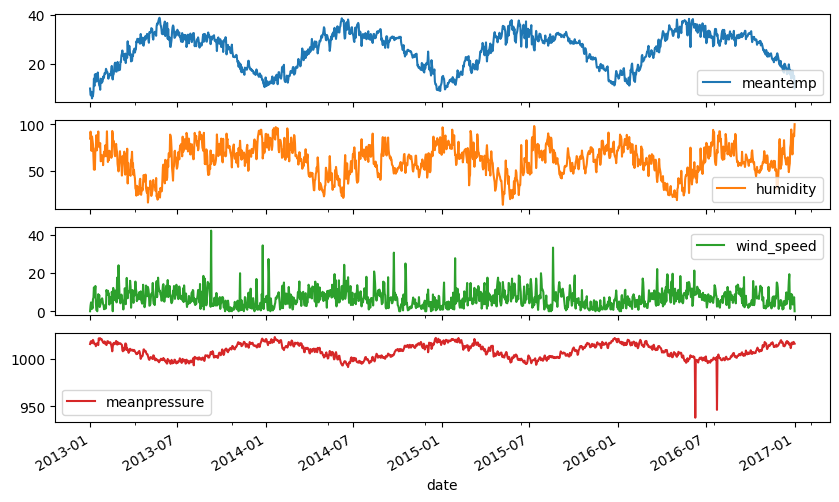

In [24]:
plot_cols =['meantemp', 'humidity', 'wind_speed', 'meanpressure']
plot_features = df_cleaned[plot_cols]
plot_features.index = date_time
plot_features.plot(subplots=True)

- Plot analyze the data with respect to years and visualize every feature according to it:
- In data the meanpressure iverall the years is consistant whereas after 2016 it show some kind of disturbance.
-  Feature `Meantemp`  indicates that in the mid year the temperature is high.

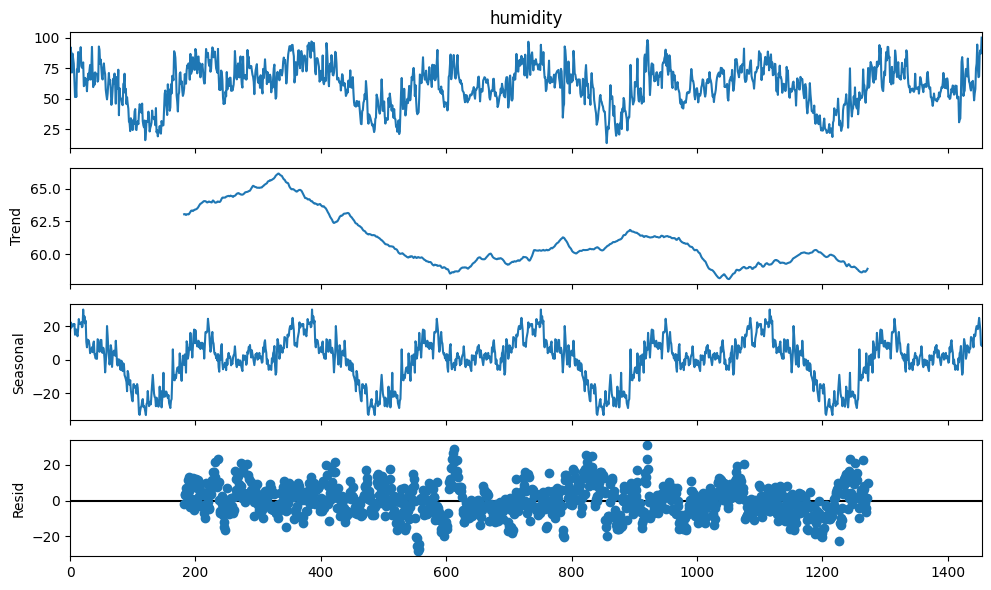

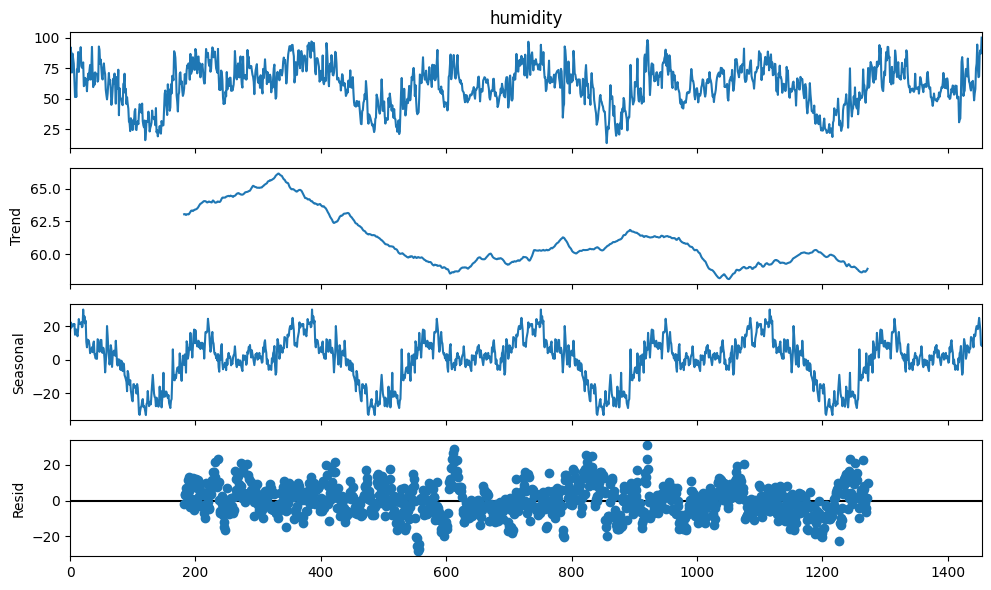

In [25]:
decompose = seasonal_decompose(df_cleaned['humidity'] , model='additive' , period=365)
decompose.plot()

# Splitting the data

In [26]:
df_cleaned.shape

(1455, 5)

In [27]:
df_cleaned

,meantemp,humidity,wind_speed,meanpressure,date_time
0,10.000000,84.500000,0.000000,1015.666667,2013-01-01
1,7.400000,92.000000,2.980000,1017.800000,2013-01-02
2,7.166667,87.000000,4.633333,1018.666667,2013-01-03
3,8.666667,71.333333,1.233333,1017.166667,2013-01-04
4,6.000000,86.833333,3.700000,1016.500000,2013-01-05
...,...,...,...,...,...
1450,17.217391,68.043478,3.547826,1015.565217,2016-12-28
1451,15.238095,87.857143,6.000000,1016.904762,2016-12-29
1452,14.095238,89.666667,6.266667,1017.904762,2016-12-30
1453,15.052632,87.000000,7.325000,1016.100000,2016-12-31


- Splitting the data in train and validation
- 20% for validation means 20% * 1455 approximately 290 , rest for training

In [28]:
test_df = pd.read_csv("/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv")
test_df

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [29]:
date_time = pd.to_datetime(test_df.pop('date'))
test_df

,meantemp,humidity,wind_speed,meanpressure
0,15.913043,85.869565,2.743478,59.000000
1,18.500000,77.222222,2.894444,1018.277778
2,17.111111,81.888889,4.016667,1018.333333
3,18.700000,70.050000,4.545000,1015.700000
4,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...
109,34.500000,27.500000,5.562500,998.625000
110,34.250000,39.375000,6.962500,999.875000
111,32.900000,40.900000,8.890000,1001.600000
112,32.875000,27.500000,9.962500,1002.125000


In [30]:
test_df['date_time'] = date_time

In [31]:
test_df

,meantemp,humidity,wind_speed,meanpressure,date_time
0,15.913043,85.869565,2.743478,59.000000,2017-01-01
1,18.500000,77.222222,2.894444,1018.277778,2017-01-02
2,17.111111,81.888889,4.016667,1018.333333,2017-01-03
3,18.700000,70.050000,4.545000,1015.700000,2017-01-04
4,18.388889,74.944444,3.300000,1014.333333,2017-01-05
...,...,...,...,...,...
109,34.500000,27.500000,5.562500,998.625000,2017-04-20
110,34.250000,39.375000,6.962500,999.875000,2017-04-21
111,32.900000,40.900000,8.890000,1001.600000,2017-04-22
112,32.875000,27.500000,9.962500,1002.125000,2017-04-23


In [32]:
val_df = df_cleaned[0:290]
train_df = df_cleaned[290:]

In [33]:
val_df.shape , train_df.shape, test_df.shape

((290, 5), (1165, 5), (114, 5))

In [34]:
# Normalize the data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean)/train_std
val_df = (val_df - train_mean)/train_std
test_df = (test_df - train_mean)/train_std

In [35]:
train_df

,meantemp,humidity,wind_speed,meanpressure,date_time
290,0.147976,0.767161,-1.448467,0.22052,-1.726361
291,-0.09071,0.544815,-0.985216,0.358046,-1.723398
292,-0.122965,0.437323,-1.108854,0.241913,-1.720436
293,-0.049585,0.17706,-1.144459,0.140296,-1.717473
294,0.346666,-0.442934,-1.448467,0.284698,-1.714511
...,...,...,...,...,...
1450,-1.086963,0.450319,-0.67112,0.87068,1.730844
1451,-1.355099,1.675689,-0.133837,1.042621,1.733806
1452,-1.509922,1.787599,-0.075409,1.170978,1.736769
1453,-1.380224,1.62268,0.156478,0.939323,1.739731


In [36]:
val_df

,meantemp,humidity,wind_speed,meanpressure,date_time
0,-2.064705,1.468068,-1.448467,0.883701,-2.585477
1,-2.416928,1.931903,-0.795534,1.157531,-2.582515
2,-2.448538,1.62268,-0.43328,1.268775,-2.579553
3,-2.245332,0.653779,-1.178238,1.076238,-2.57659
4,-2.606586,1.612372,-0.637778,0.990666,-2.573628
...,...,...,...,...,...
285,0.260868,1.45776,-1.313352,-0.143161,-1.741173
286,0.335054,0.871708,-0.230869,-0.228733,-1.738211
287,0.083466,0.968893,-0.637778,0.04632,-1.735248
288,0.160878,0.880543,-1.448467,0.027983,-1.732286


In [37]:
test_df

,meantemp,humidity,wind_speed,meanpressure,date_time
0,-1.263664,1.552768,-0.847357,-121.9119,1.742694
1,-0.913208,1.017976,-0.81428,1.218858,1.745656
2,-1.101361,1.306585,-0.568395,1.225989,1.748619
3,-0.886114,0.574412,-0.452635,0.88798,1.751581
4,-0.92826,0.877107,-0.72542,0.712558,1.754544
...,...,...,...,...,...
109,1.254316,-2.05708,-0.229695,-1.303729,2.065603
110,1.220449,-1.322675,0.077052,-1.143282,2.068566
111,1.037564,-1.228361,0.499377,-0.921865,2.071528
112,1.034177,-2.05708,0.734367,-0.854477,2.07449


In [38]:
def make_sequence(df, sequence_length):
    X = [] 
    target = []
    for i in range(len(df) - sequence_length):
        s = df.iloc[i : i + sequence_length].values 
        t = df.iloc[i + sequence_length, 0]         # target is meantemp
        X.append(s)
        target.append(t)
    return np.array(X), np.array(target)

In [39]:
# making sequence form for data , they contain 4  feature for ds and 1 feature for target(temp)
seq = 28     # sequential length , choosed 4 week timestemp b/c its the daily data set 
ds_train , target_train = make_sequence(train_df, sequence_length=seq)
ds_val , target_val = make_sequence(val_df ,sequence_length=seq)
ds_test , target_test = make_sequence(test_df, sequence_length=seq)
ds_train.shape , ds_val.shape , ds_test.shape

((1137, 28, 5), (262, 28, 5), (86, 28, 5))

In [40]:
# Check the shapes of the resulting datasets
print("Training Dataset Shape:", ds_train.shape)  # Should be (number_of_train_sequences, 28, number_of_features)
print("Training Target Shape:", target_train.shape)  # Should be (number_of_train_sequences,)
print("Validation Dataset Shape:", ds_val.shape)  # Should be (number_of_val_sequences, 28, number_of_features)
print("Validation Target Shape:", target_val.shape)  # Should be (number_of_val_sequences,)
print("Test Dataset Shape:", ds_test.shape)  # Should be (number_of_test_sequences, 28, number_of_features)
print("Test Target Shape:", target_test.shape)  # Should be (number_of_test_sequences,)

Training Dataset Shape: (1137, 28, 5)
Training Target Shape: (1137,)
Validation Dataset Shape: (262, 28, 5)
Validation Target Shape: (262,)
Test Dataset Shape: (86, 28, 5)
Test Target Shape: (86,)


In [41]:
#### Ensure your data is in the correct format (NumPy arrays)
ds_train = np.array(ds_train, dtype=np.float32)
target_train = np.array(target_train, dtype=np.float32)
ds_val = np.array(ds_val, dtype=np.float32)
target_val = np.array(target_val, dtype=np.float32)
ds_test = np.array(ds_test, dtype=np.float32)
target_test = np.array(target_test, dtype=np.float32)

In [42]:
print("Training Features Shape:", ds_train.shape)
print("Training Target Shape:", target_train.shape)
print("Validation Features Shape:", ds_val.shape)
print("Validation Target Shape:", target_val.shape)
print("Test Features Shape:", ds_test.shape)
print("Test Target Shape:", target_test.shape)

print("\nData Types:")
print("Training Features Data Type:", ds_train.dtype)
print("Training Target Data Type:", target_train.dtype)
print("Validation Features Data Type:", ds_val.dtype)
print("Validation Target Data Type:", target_val.dtype)
print("Test Features Data Type:", ds_test.dtype)
print("Test Target Data Type:", target_test.dtype)

Training Features Shape: (1137, 28, 5)
Training Target Shape: (1137,)
Validation Features Shape: (262, 28, 5)
Validation Target Shape: (262,)
Test Features Shape: (86, 28, 5)
Test Target Shape: (86,)

Data Types:
Training Features Data Type: float32
Training Target Data Type: float32
Validation Features Data Type: float32
Validation Target Data Type: float32
Test Features Data Type: float32
Test Target Data Type: float32


- The data types of each array confirmed that they are float32 and shapes are also in proper manner let proceed further.

In [43]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Define the LSTM model
model = Sequential()

# LSTM layer 
model.add(LSTM(50, activation='relu', input_shape=(ds_train.shape[1], ds_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

# Adding a second LSTM layer
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))

# Output layer with 1 unit for regression (target variable)
model.add(Dense(1))

# 2. Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 4.Train the model
history = model.fit(ds_train, target_train, 
                    validation_data=(ds_val, target_val), 
                    epochs=100, 
                    batch_size=32, 
                    callbacks=[early_stopping])

# 5. Evaluate the model on the test set
test_loss = model.evaluate(ds_test, target_test, verbose=1)
print(f'Test Loss: {test_loss}')

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.5665 - val_loss: 0.0825
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1435 - val_loss: 0.1618
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1364 - val_loss: 0.1193
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1160 - val_loss: 0.1378
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1066 - val_loss: 0.1140
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1067 - val_loss: 0.1108
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1128 - val_loss: 0.0985
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0953 - val_loss: 0.0854
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0953 - val_loss: 0.0805
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0867 - val_loss: 0.0806
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0894 - val_loss: 0.1030
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

# Calculate metrices

In [44]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Make predictions on the test set
predictions = model.predict(ds_test)

# Calculate additional metrics
mae = mean_absolute_error(target_test, predictions)
mape = mean_absolute_percentage_error(target_test, predictions)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
Mean Absolute Error: 0.5158098936080933
Mean Absolute Percentage Error: 1.258102297782898


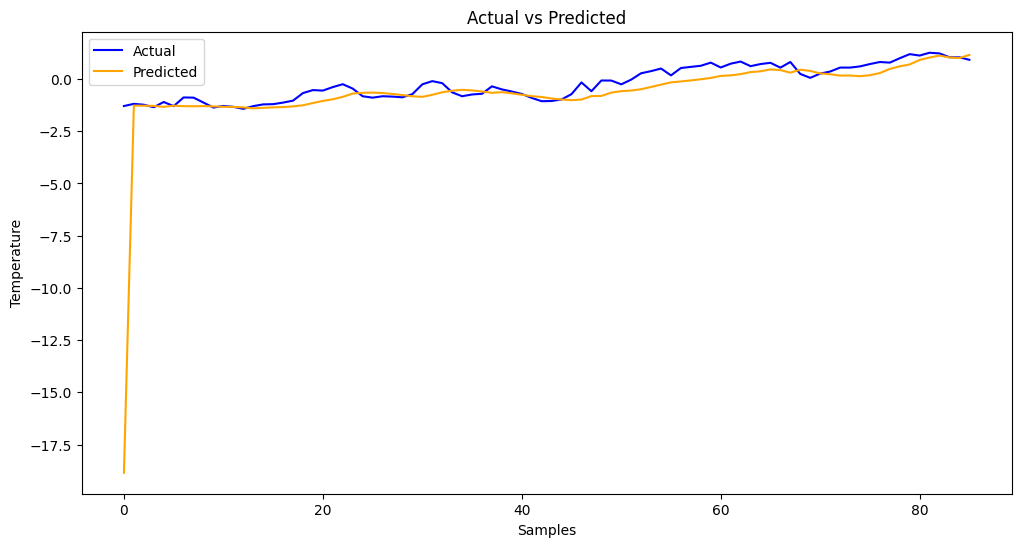

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(target_test, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='orange')
plt.title('Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Temperature')
plt.legend()
plt.show()

>Both MAE and MAPE suggest that your model is making reasonably accurate predictions. An MAE of 0.7 and a MAPE of 1.74% indicate that the model has a good level of accuracy in predicting temperature values.